# Last Notebook
### Assignment Advanced Machine Learning | Benjamin Amar - Rozowykwiat | 16/12/2023

*Involvment of Generative AI (ChatGPT and other LLMs) for inspiration and code optimization*

In this notebook, you will have to predict whether a candidate was hired or not (i.e., predict the column `embauche`).
The dataset is composed of 11 columns (features):
- date – application date 
– age: age of the candidate
- diplome – Highest diploma obtained (bac, licence, master, doctorat)
- specialite – speciality of the diploma (geology, detective, archeology, . . . )
- salaire – salaire demanded by the candidate
- dispo – oui : immediate avaialability, non : not available immediately
- sexe – female (F) or male (M)
- exp – nbr of years of experience
- cheveux – color of hair (châtain, brun, blond, roux)
- note – grade (over 100) obtained on the exercise
- embauche – 1: the candidate got hired, 0 the candidate did not get hired.

To complete this test, you will have to:
1. Split the data into train (70%), validation(10%), and test(20%) sets. 
2. Explore the data: look at your data, their types, check for missing values, incorrect values, duplicates, do some visualizations, set a list of changes you need to apply on these columns (one-hot encode some columns, bin others, eliminate others, etc.), check for balance or imbalance.
3. Apply the feature engineering you have identified in the previous step (the one-hot encoding, etc.)
4. Identify the metric to be optimized here (is it accuracy, precision, recall, f1-score, etc.)
5. Try several Machine Learning Models and do hyperparameter tuning using the validation set to find the best performing model.
6. Test your best model (or ensemble of models) on the test set, explain the results you got, and recommend on next steps (modifications that might bring better results).

Bonus: Deal with imbalance if any.


# Step 0 - Import Libraries

In [1]:
pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Libraries

In [2]:
#Importing all libraries
import os
import pandas as pd
%pylab inline
import seaborn as sns
import geopandas
import folium
from folium.plugins import HeatMap
import sys
import openpyxl
import datetime
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report, recall_score
from lightgbm import LGBMClassifier

import import_ipynb

Populating the interactive namespace from numpy and matplotlib


## Step 0.1 - Import dataset here 🖍️

In [3]:
path = "data.csv"
data = pd.DataFrame()

if path.endswith('.csv'):
    data = pd.read_csv(path, index_col=0)

elif path.endswith('.xlsx') or path.endswith('.xls'):
    data = pd.read_excel(path)

elif path.endswith('.txt'):
    data = pd.read_csv(path, sep='*', encoding='latin')

else:
    print(f"Unsupported file format. Please provide a .csv or .xlsx file")
    
if data is not None:
    print(f"Dataframe {path} loaded successfully! 👍")

Dataframe data.csv loaded successfully! 👍


In [4]:
datac = data.copy()

# Step 1 - Data Frame Observation

## 1.1 - Dataframe type

In [5]:
datac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       20000 non-null  int64  
 1   date        19909 non-null  object 
 2   cheveux     19897 non-null  object 
 3   age         19909 non-null  float64
 4   exp         19904 non-null  float64
 5   salaire     19905 non-null  float64
 6   sexe        19900 non-null  object 
 7   diplome     19890 non-null  object 
 8   specialite  19907 non-null  object 
 9   note        19886 non-null  float64
 10  dispo       19894 non-null  object 
 11  embauche    20000 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 2.0+ MB


In [6]:
datac.head()

,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


## 1.2 - Features type consistency

In [7]:
import pandas as pd

# Initialize a dictionary to store type consistency and NaN percentage
type_consistency = {}

# Iterate through DataFrame columns
for column in datac:
    # Get the unique data types in the column
    unique_types = datac[column].apply(type).unique()
    
    # Calculate the percentage of NaN values in the column
    nan_percentage = datac[column].isna().mean() * 100

    # Construct the result string based on type consistency and NaN percentage
    if len(unique_types) == 1:
        consistency_result = f"🟢 {column}: Consistent ({unique_types[0].__name__})"
    else:
        consistency_result = f"🔴 {column}: Inconsistent ({', '.join(t.__name__ for t in unique_types)})"

    # Add the NaN percentage to the result string
    consistency_result += f"| NaN Values: {nan_percentage:.2f}% ({sum(datac[column].isna())})"

    # Store the result in the dictionary
    type_consistency[column] = consistency_result

# Print the type consistency results for each feature
for consistency in type_consistency.values():
    print(consistency + '\n')
    # Optionally write to an output file
    # output_file.write(consistency + '\n')

🟢 index: Consistent (int)| NaN Values: 0.00% (0)

🔴 date: Inconsistent (str, float)| NaN Values: 0.46% (91)

🔴 cheveux: Inconsistent (str, float)| NaN Values: 0.52% (103)

🟢 age: Consistent (float)| NaN Values: 0.46% (91)

🟢 exp: Consistent (float)| NaN Values: 0.48% (96)

🟢 salaire: Consistent (float)| NaN Values: 0.47% (95)

🔴 sexe: Inconsistent (str, float)| NaN Values: 0.50% (100)

🔴 diplome: Inconsistent (str, float)| NaN Values: 0.55% (110)

🔴 specialite: Inconsistent (str, float)| NaN Values: 0.46% (93)

🟢 note: Consistent (float)| NaN Values: 0.57% (114)

🔴 dispo: Inconsistent (str, float)| NaN Values: 0.53% (106)

🟢 embauche: Consistent (int)| NaN Values: 0.00% (0)



## 1.3 - Describe numerical features

In [8]:
datac.describe(percentiles=[.01, .25, .5, .75, .99])

,index,age,exp,salaire,note,embauche
count,20000.000000,19909.000000,19904.000000,19905.000000,19886.000000,20000.000000
mean,9999.500000,35.004521,9.500352,34974.343934,75.168762,0.114600
std,5773.647028,9.609169,3.012109,5003.099616,17.095926,0.318547
min,0.000000,-3.000000,-2.000000,14128.000000,8.680000,0.000000
1%,199.990000,13.000000,3.000000,23328.240000,35.267000,0.000000
25%,4999.750000,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,9999.500000,35.000000,9.000000,34979.000000,75.080000,0.000000
75%,14999.250000,41.000000,12.000000,38358.000000,86.617500,0.000000
99%,19799.010000,58.000000,16.000000,46801.840000,114.700000,1.000000
max,19999.000000,74.000000,23.000000,53977.000000,143.220000,1.000000


## 1.4 - Describe categorical features

In [9]:
try:
    print(datac.describe(include='object'))
except ValueError:
    print("🟨 Warning! There are no categorical features in this DataSet!")

              date  cheveux   sexe diplome specialite  dispo
count        19909    19897  19900   19890      19907  19894
unique        1826        4      2       4          4      2
top     2012-02-03  chatain      M  master   geologie    non
freq            24     6022  11889    7513      10028  11848


# Step 2 - Univariate Analysis

## 2.1 - Numerical Univariate Analysis

🔵 Feature : index

Central tendency measurement :
 * Mean:  9999.5
 * Median:  9999.5

Dispersion measurement :
 * Variance:  33333333.25
 * Standard deviation:  5773.502684679379

Shape measurement :
 * Skewness:  0.0
 * Kurtosis:  -1.2000000000000002

P1 and P99 :
 * P1:  199.99
 * P5:  999.95
 * P25:  4999.75
 * P50:  9999.5
 * P75:  14999.25
 * P95:  18999.05
 * P99:  19799.01

Outlier test :
✅ No outliers detected.


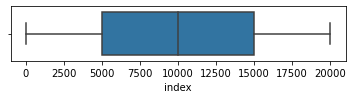

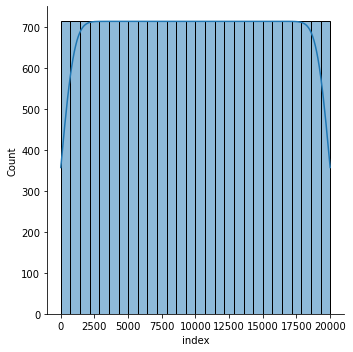

------------------------------





🔵 Feature : age

Central tendency measurement :
 * Mean:  35.00452056858707
 * Median:  35.0

Dispersion measurement :
 * Variance:  92.33148792751031
 * Standard deviation:  9.608927511825152

Shape measurement :
 * Skewness:  0.011698999981921634
 * Kurtosis:  0.14144882885294985

P1 and P99 :
 * P1:  13.0
 * P5:  19.0
 * P25:  29.0
 * P50:  35.0
 * P75:  41.0
 * P95:  51.0
 * P99:  58.0

Outlier test :
🚨 Warning Outliers detected:
 * High outliers:
       index        date  cheveux   age   exp  salaire sexe   diplome  \
75        75  2014-12-13     brun  61.0   9.0  32275.0    M    master   
142      142  2011-04-25    blond  65.0  10.0  38355.0    F   licence   
278      278  2011-09-20     brun  62.0   8.0  42190.0    M   licence   
530      530  2013-06-20    blond  67.0   3.0  23851.0    F   licence   
635      635  2013-07-28     brun  61.0  16.0  33535.0    M    master   
...      ...         ...      ...   ...   ...      ...  ...       ... 

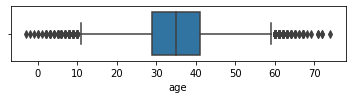

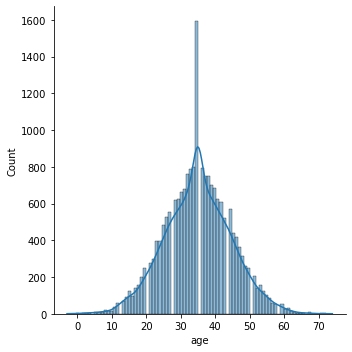

------------------------------





🔵 Feature : exp

Central tendency measurement :
 * Mean:  9.500351688102894
 * Median:  9.0

Dispersion measurement :
 * Variance:  9.072347143197158
 * Standard deviation:  3.01203372212151

Shape measurement :
 * Skewness:  0.0063825813349276
 * Kurtosis:  -0.05424936883708131

P1 and P99 :
 * P1:  3.0
 * P5:  5.0
 * P25:  7.0
 * P50:  9.0
 * P75:  12.0
 * P95:  14.0
 * P99:  16.0

Outlier test :
🚨 Warning Outliers detected:
 * High outliers:
       index        date  cheveux   age   exp  salaire sexe  diplome  \
1427    1427  2011-09-27    blond  35.0  21.0  31886.0    F  licence   
4850    4850  2011-10-12     roux  30.0  20.0  41417.0    M      bac   
9415    9415  2012-11-14  chatain  38.0  23.0  49013.0    F      bac   
11005  11005  2014-03-17  chatain  45.0  20.0  24648.0    M  licence   
11404  11404  2010-08-26  chatain  35.0  20.0  29957.0    M   master   
13272  13272  2011-12-16     brun  18.0  20.0  39779.0    M  licence   

      spec

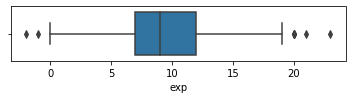

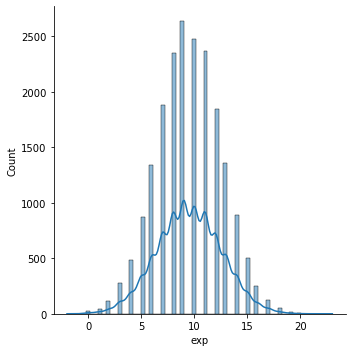

------------------------------





🔵 Feature : salaire

Central tendency measurement :
 * Mean:  34974.343933685006
 * Median:  34979.0

Dispersion measurement :
 * Variance:  25029748.248853497
 * Standard deviation:  5002.973940453167

Shape measurement :
 * Skewness:  -0.005518970717293871
 * Kurtosis:  -0.0022734398321277993

P1 and P99 :
 * P1:  23328.24
 * P5:  26720.8
 * P25:  31596.0
 * P50:  34979.0
 * P75:  38358.0
 * P95:  43147.6
 * P99:  46801.839999999975

Outlier test :
🚨 Warning Outliers detected:
 * High outliers:
       index        date  cheveux   age   exp  salaire sexe  diplome  \
115      115  2013-04-04  chatain  34.0   6.0  50575.0    M      bac   
976      976  2010-03-18  chatain  34.0   8.0  49761.0    F  licence   
1657    1657  2014-06-09     roux  38.0   8.0  49926.0    M  licence   
1760    1760  2014-05-13  chatain  32.0  11.0  50428.0    M      bac   
3083    3083  2014-12-22  chatain  41.0   7.0  53479.0    M  licence   
...      ...         ...      

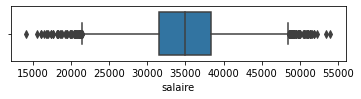

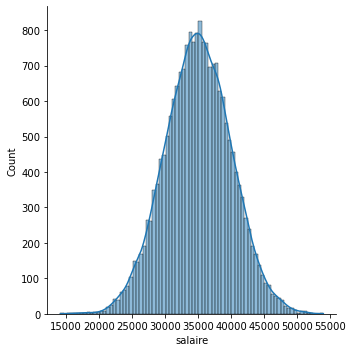

------------------------------





🔵 Feature : note

Central tendency measurement :
 * Mean:  75.16876194307517
 * Median:  75.08

Dispersion measurement :
 * Variance:  292.2560033249055
 * Standard deviation:  17.09549658023731

Shape measurement :
 * Skewness:  -0.009945619016416003
 * Kurtosis:  0.008052509637702876

P1 and P99 :
 * P1:  35.267
 * P5:  47.1125
 * P25:  63.72
 * P50:  75.08
 * P75:  86.6175
 * P95:  103.45
 * P99:  114.70000000000002

Outlier test :
🚨 Warning Outliers detected:
 * High outliers:
       index        date  cheveux   age   exp  salaire sexe   diplome  \
394      394  2012-04-19  chatain  19.0  12.0  23243.0    F  doctorat   
421      421  2014-04-08  chatain  43.0  11.0  28965.0    F  doctorat   
737      737  2012-03-10     brun  38.0  11.0  30838.0    F  doctorat   
1265    1265  2011-04-19    blond  53.0  12.0  28453.0    F  doctorat   
1272    1272  2011-04-21     brun  26.0   9.0  33524.0    F  doctorat   
...      ...         ...      ...   ... 

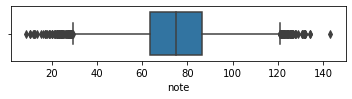

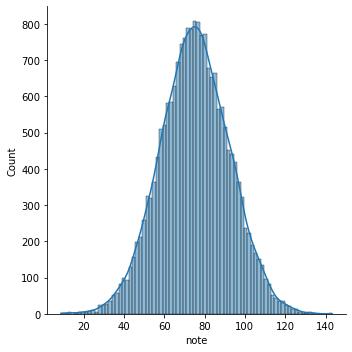

------------------------------





🔵 Feature : embauche

Central tendency measurement :
 * Mean:  0.1146
 * Median:  0.0

Dispersion measurement :
 * Variance:  0.10146684000003654
 * Standard deviation:  0.3185386004867174
🚨 Warning Standard deviation 277.95689396746724 times bigger than mean

Shape measurement :
 * Skewness:  2.419982427131167
 * Kurtosis:  3.85670060768586

P1 and P99 :
 * P1:  0.0
 * P5:  0.0
 * P25:  0.0
 * P50:  0.0
 * P75:  0.0
 * P95:  1.0
 * P99:  1.0

Outlier test :
🚨 Warning Outliers detected:
 * High outliers:
       index        date  cheveux   age   exp  salaire sexe   diplome  \
5          5  2014-02-12  chatain  37.0   8.0  38558.0    M    master   
8          8  2014-10-17  chatain  43.0  10.0  28625.0    M  doctorat   
9          9  2011-06-04  chatain  28.0  11.0  32454.0    M    master   
34        34  2010-06-21    blond  38.0   6.0  41909.0    M   licence   
37        37  2013-01-10     brun  26.0  11.0  31759.0    F    master   
...      ...    

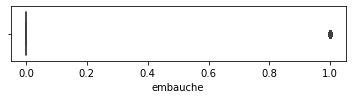

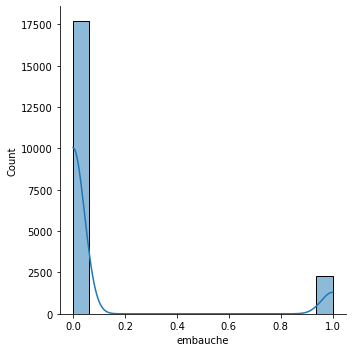

------------------------------





Finished! :D


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numerical_features = datac.select_dtypes(include=np.number).columns

for c in numerical_features:
    print(f"🔵 Feature : {c}\n")
    
    # Central tendency measurement
    print("Central tendency measurement :")
    print(" * Mean: ", datac[c].mean())
    print(" * Median: ", datac[c].median())
    
    # Dispersion measurement
    print("\nDispersion measurement :")
    print(" * Variance: ", datac[c].var(ddof=0))
    print(" * Standard deviation: ", datac[c].std(ddof=0))
    
    if (datac[c].mean() * datac[c].std(ddof=0)) >= 0 and datac[c].std(ddof=0) >= datac[c].mean():
        print(f"🚨 Warning Standard deviation {datac[c].std(ddof=0) / datac[c].mean() * 100} times bigger than mean")
    
    # Shape measurement
    print("\nShape measurement :")
    print(" * Skewness: ", datac[c].skew())
    print(" * Kurtosis: ", datac[c].kurtosis())
    
    # P1 and P99
    Q1 = datac[c].quantile(0.25)
    Q3 = datac[c].quantile(0.75)
    print("\nP1 and P99 :")
    print(" * P1: ", datac[c].quantile(0.01))
    print(" * P5: ", datac[c].quantile(0.05))
    print(" * P25: ", Q1)
    print(" * P50: ", datac[c].quantile(0.50))
    print(" * P75: ", Q3)
    print(" * P95: ", datac[c].quantile(0.95))
    print(" * P99: ", datac[c].quantile(0.99))
    
    # Outlier test
    print("\nOutlier test :")
    IQR = Q3 - Q1
    
    high_outliers = datac[(datac[c] > Q3 + 1.5 * IQR)]
    low_outliers = datac[(datac[c] < Q1 - 1.5 * IQR)]
    
    if not high_outliers.empty or not low_outliers.empty:
        print("🚨 Warning Outliers detected:")
        if not high_outliers.empty:
            print(" * High outliers:")
            print(high_outliers)
        print()
        if not low_outliers.empty:
            print(" * Low outliers:")
            print(low_outliers)
    else:
        print("✅ No outliers detected.")
    
    # Box plot and distribution plot
    plt.figure(figsize=(6, 1))
    sns.boxplot(x=c, data=datac)
    plt.xlabel(c)
    plt.show()
    sns.displot(x=c, data=datac, kde=True)
    plt.show()
    
    print("------------------------------\n\n\n\n\n")

print("Finished! :D")

## 2.2 - Categorical Univariate Analysis

🔵 Feature : cheveux



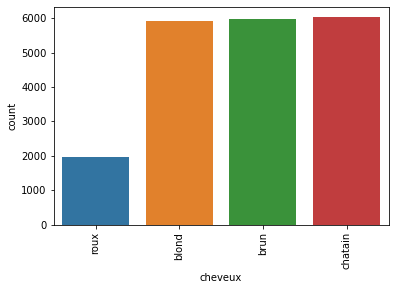

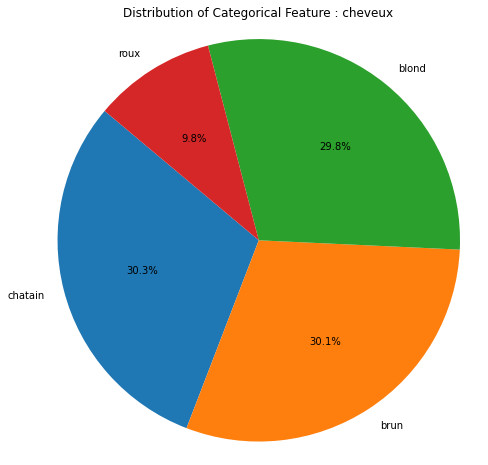

{'chatain': 6022, 'brun': 5991, 'blond': 5929, 'roux': 1955}

------------------------------





🔵 Feature : sexe



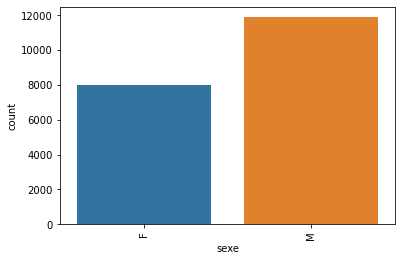

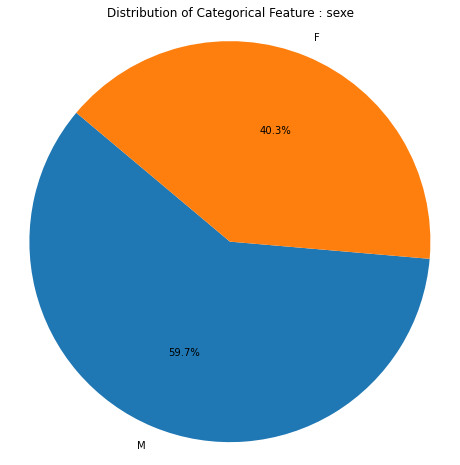

{'M': 11889, 'F': 8011}

------------------------------





🔵 Feature : diplome



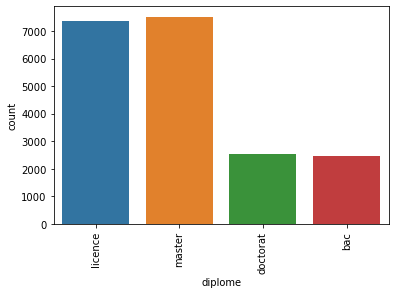

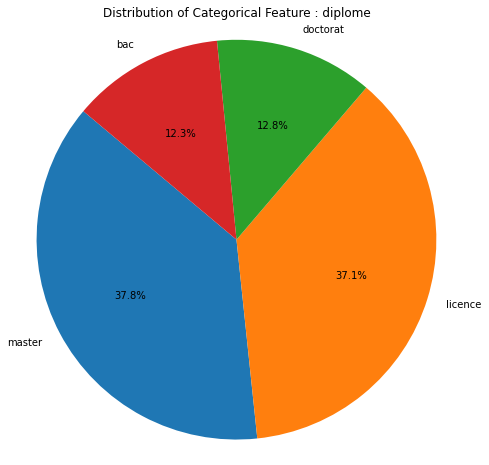

{'master': 7513, 'licence': 7377, 'doctorat': 2547, 'bac': 2453}

------------------------------





🔵 Feature : specialite



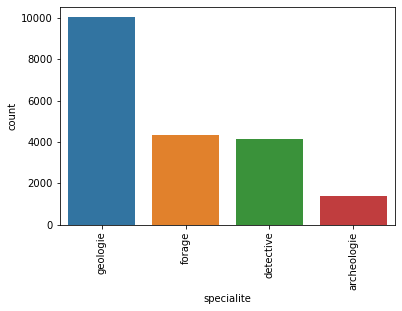

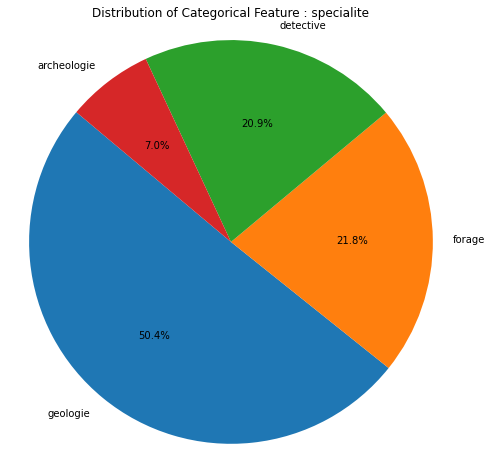

{'geologie': 10028, 'forage': 4340, 'detective': 4155, 'archeologie': 1384}

------------------------------





🔵 Feature : dispo



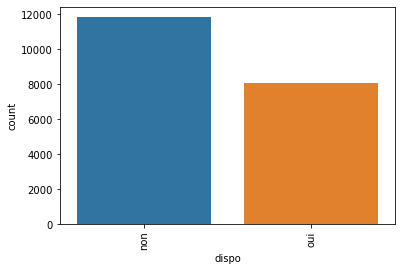

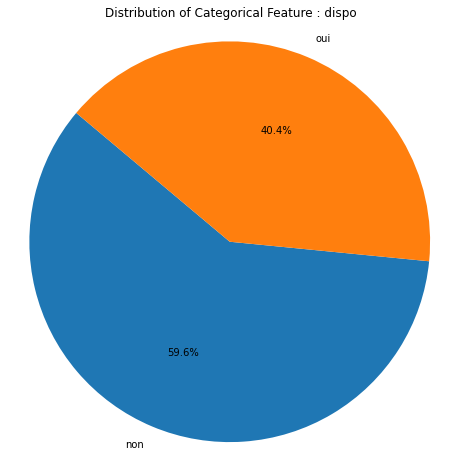

{'non': 11848, 'oui': 8046}

------------------------------





Finished! :D


In [11]:
categorical_features = datac.select_dtypes(include='object').columns
categorical_features = categorical_features.drop('date')


for c in categorical_features:
    # Create a count plot
    sns.countplot(data=datac, x=c)
    plt.xticks(rotation=90)
    print(f"🔵 Feature : {c}\n")
    plt.show()
    
    print()
    
    # Create a pie chart
    pie_data = datac[c].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f"Distribution of Categorical Feature : {c}")
    plt.show()
    
    # Print value counts as a dictionary
    print(pie_data.to_dict())
    print("\n------------------------------\n\n\n\n\n")

print("Finished! :D")

# Step 3 - Bivariate Analysis

## 3.1 - Numerical Bivariate Analysis

Text(0.5, 1.0, 'Features correlation matrix')

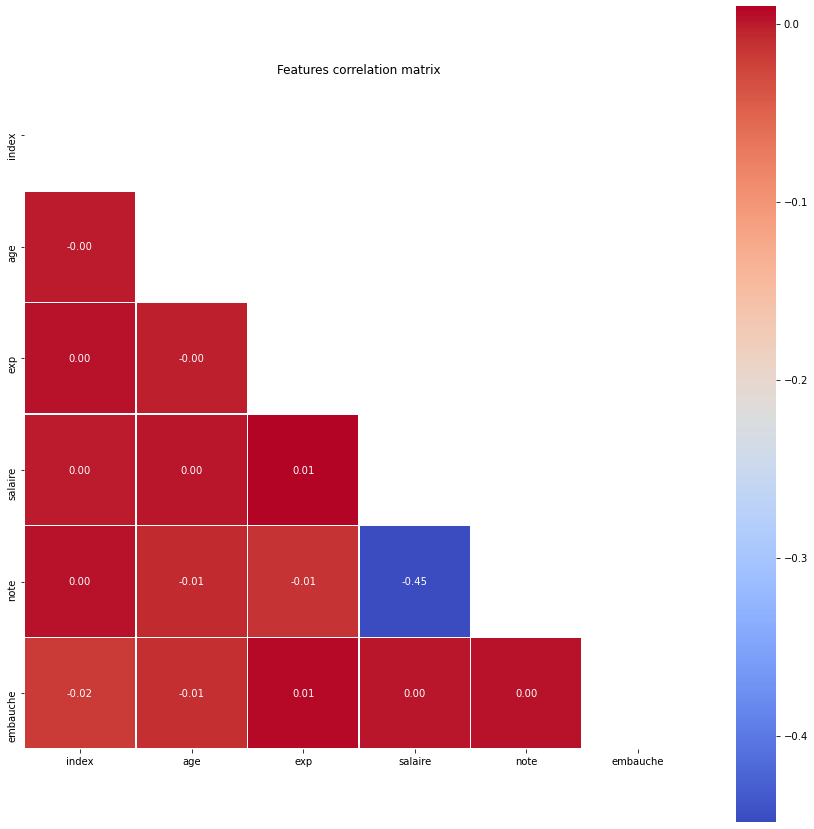

In [12]:
#Creating a correlation map between the numerical features
corr_matrix = datac.corr()
mask = np.triu(corr_matrix)
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap='coolwarm', mask=mask, linewidths=.5, cbar=True, square=True, annot=True, fmt=".2f")
plt.title("Features correlation matrix")

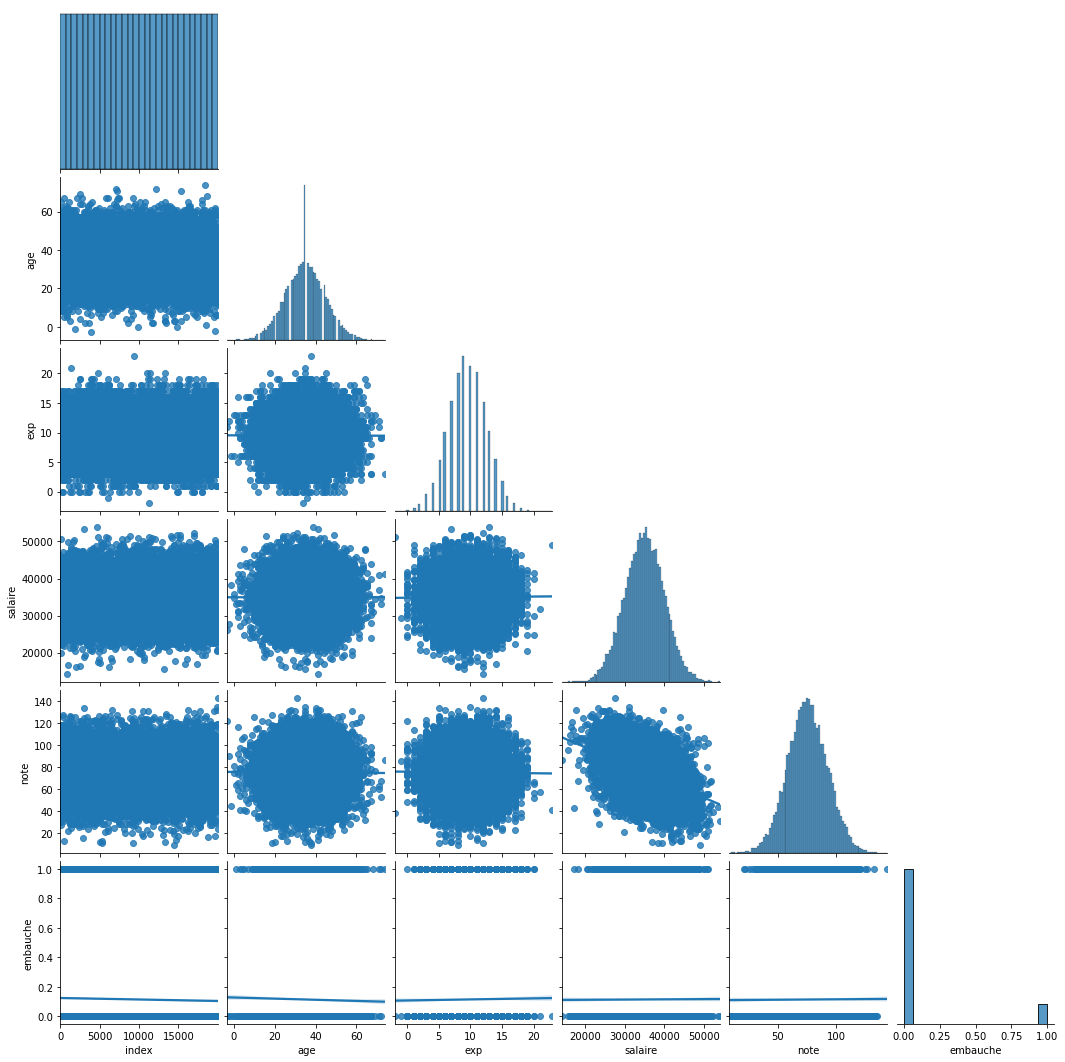

In [13]:
sns.pairplot(datac, kind='reg', corner=True)

## 3.2 - Categorical Bivariate Analysis

🔵 Features: cheveux vs. sexe

 * Chi-Square Test of Independence:
   - Chi-Square Value: 1759.8348597983183
   - p-value: 0.0


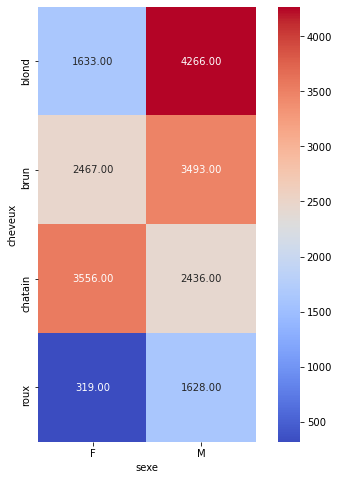


------------------------------




🔵 Features: cheveux vs. diplome

 * Chi-Square Test of Independence:
   - Chi-Square Value: 6119.179506034312
   - p-value: 0.0


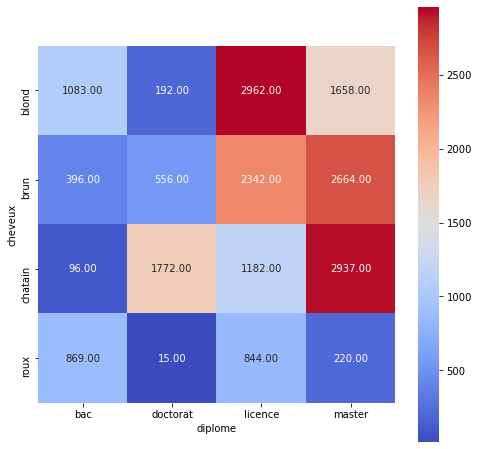


------------------------------




🔵 Features: cheveux vs. specialite

 * Chi-Square Test of Independence:
   - Chi-Square Value: 493.12385788854414
   - p-value: 1.7052779988381877e-100


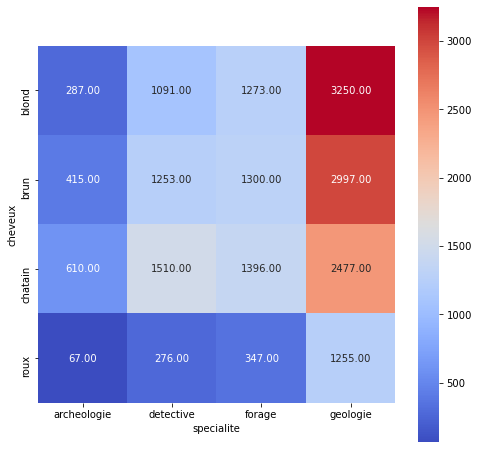


------------------------------




🔵 Features: cheveux vs. dispo

 * Chi-Square Test of Independence:
   - Chi-Square Value: 312.14486312160125
   - p-value: 2.339413824949941e-67


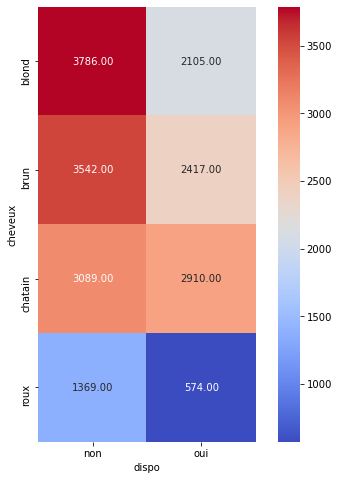


------------------------------




🔵 Features: sexe vs. cheveux

 * Chi-Square Test of Independence:
   - Chi-Square Value: 1759.8348597983181
   - p-value: 0.0


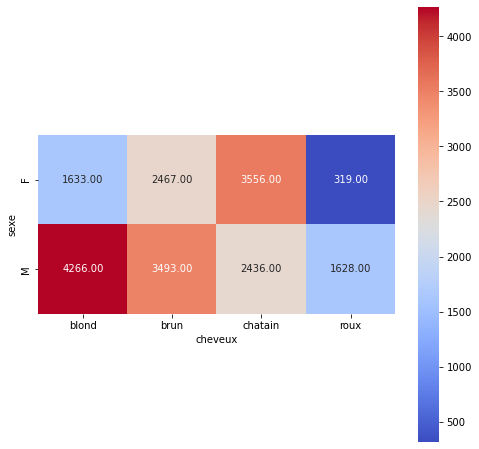


------------------------------




🔵 Features: sexe vs. diplome

 * Chi-Square Test of Independence:
   - Chi-Square Value: 76.22515938788814
   - p-value: 1.979226955646909e-16


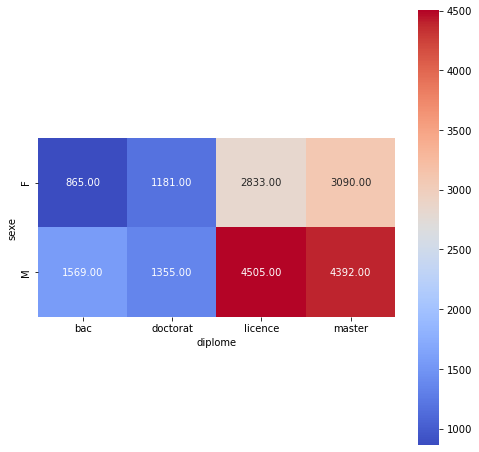


------------------------------




🔵 Features: sexe vs. specialite

 * Chi-Square Test of Independence:
   - Chi-Square Value: 2707.887156104577
   - p-value: 0.0


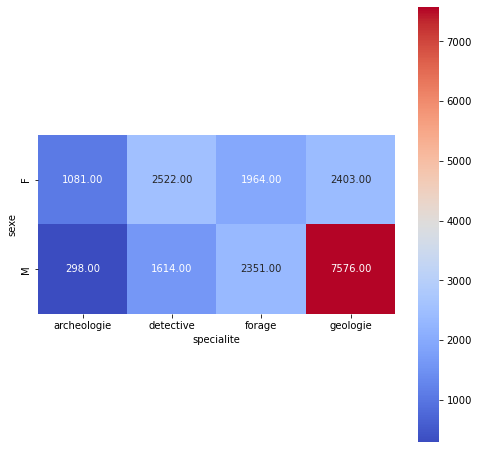


------------------------------




🔵 Features: sexe vs. dispo

 * Chi-Square Test of Independence:
   - Chi-Square Value: 91.03401296418394
   - p-value: 1.4122357698725133e-21


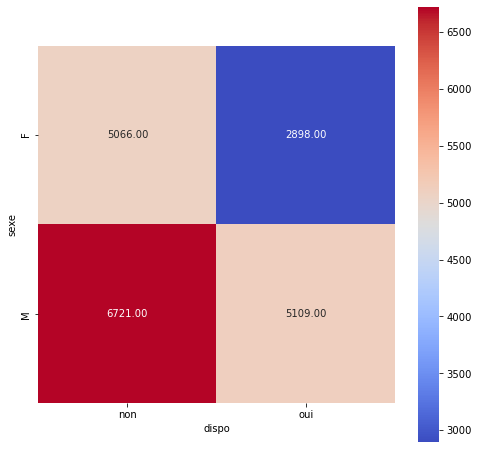


------------------------------




🔵 Features: diplome vs. cheveux

 * Chi-Square Test of Independence:
   - Chi-Square Value: 6119.179506034313
   - p-value: 0.0


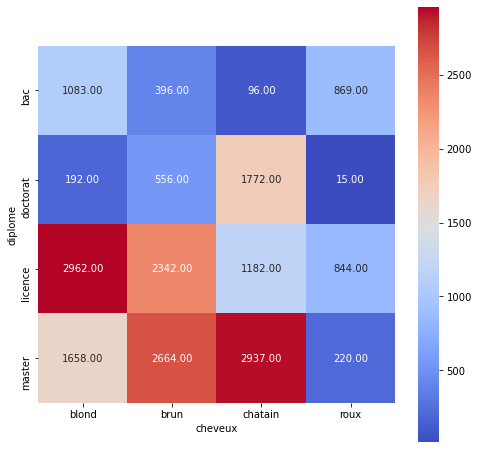


------------------------------




🔵 Features: diplome vs. sexe

 * Chi-Square Test of Independence:
   - Chi-Square Value: 76.22515938788814
   - p-value: 1.979226955646909e-16


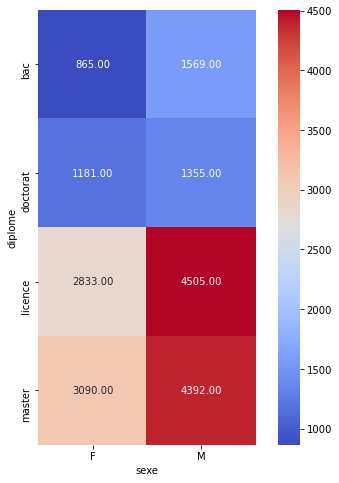


------------------------------




🔵 Features: diplome vs. specialite

 * Chi-Square Test of Independence:
   - Chi-Square Value: 381.5783771575889
   - p-value: 1.1630550972936369e-76


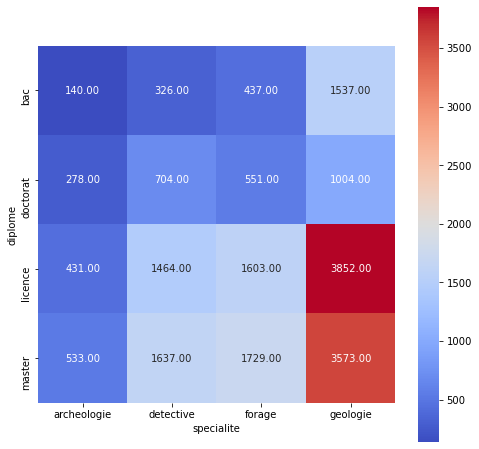


------------------------------




🔵 Features: diplome vs. dispo

 * Chi-Square Test of Independence:
   - Chi-Square Value: 4248.649838487042
   - p-value: 0.0


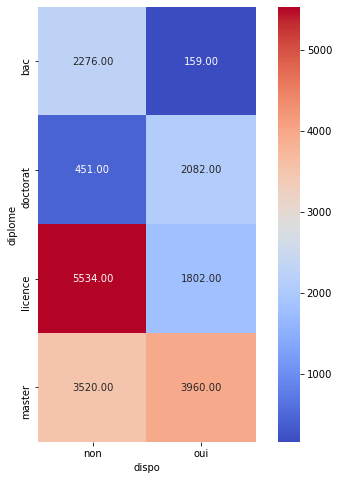


------------------------------




🔵 Features: specialite vs. cheveux

 * Chi-Square Test of Independence:
   - Chi-Square Value: 493.1238578885442
   - p-value: 1.7052779988381385e-100


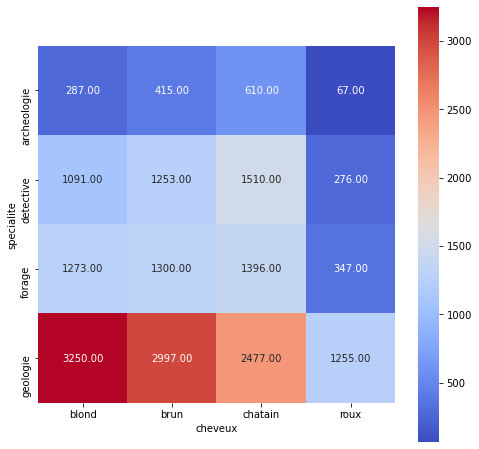


------------------------------




🔵 Features: specialite vs. sexe

 * Chi-Square Test of Independence:
   - Chi-Square Value: 2707.887156104577
   - p-value: 0.0


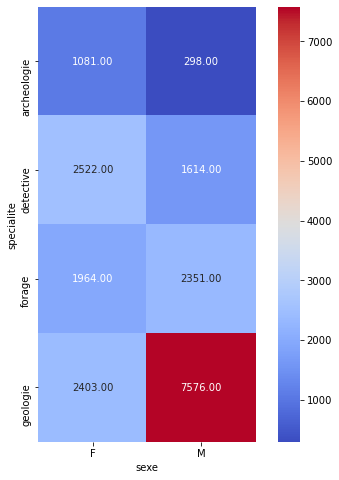


------------------------------




🔵 Features: specialite vs. diplome

 * Chi-Square Test of Independence:
   - Chi-Square Value: 381.5783771575888
   - p-value: 1.1630550972936707e-76


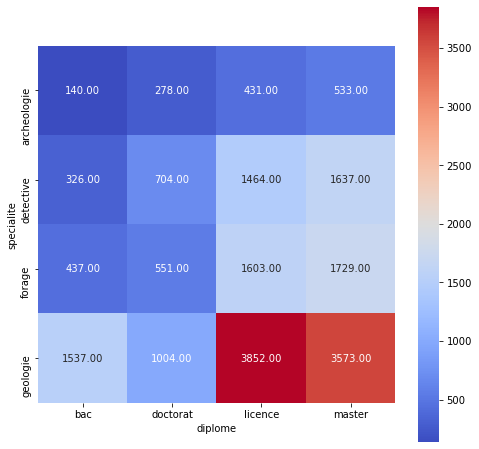


------------------------------




🔵 Features: specialite vs. dispo

 * Chi-Square Test of Independence:
   - Chi-Square Value: 2922.4259105585825
   - p-value: 0.0


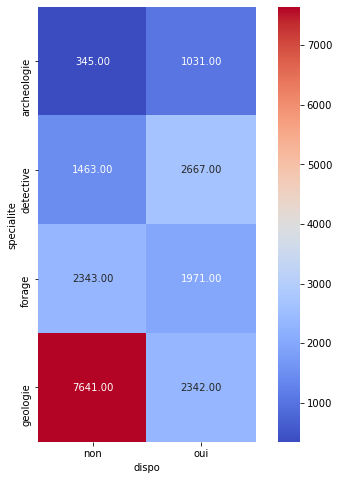


------------------------------




🔵 Features: dispo vs. cheveux

 * Chi-Square Test of Independence:
   - Chi-Square Value: 312.14486312160125
   - p-value: 2.339413824949941e-67


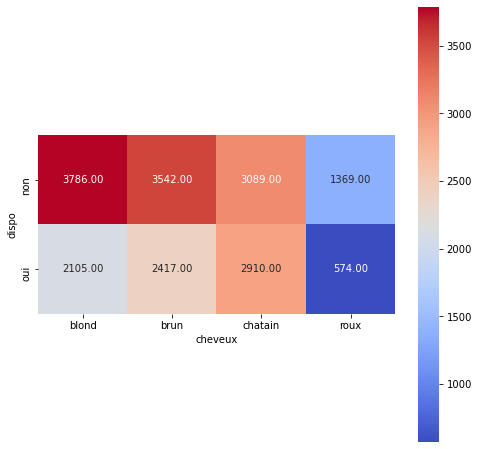


------------------------------




🔵 Features: dispo vs. sexe

 * Chi-Square Test of Independence:
   - Chi-Square Value: 91.03401296418394
   - p-value: 1.4122357698725133e-21


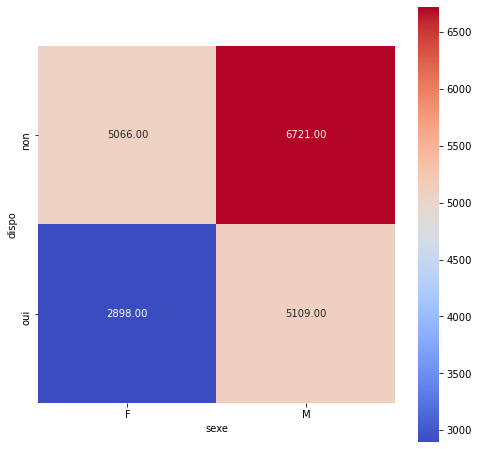


------------------------------




🔵 Features: dispo vs. diplome

 * Chi-Square Test of Independence:
   - Chi-Square Value: 4248.649838487042
   - p-value: 0.0


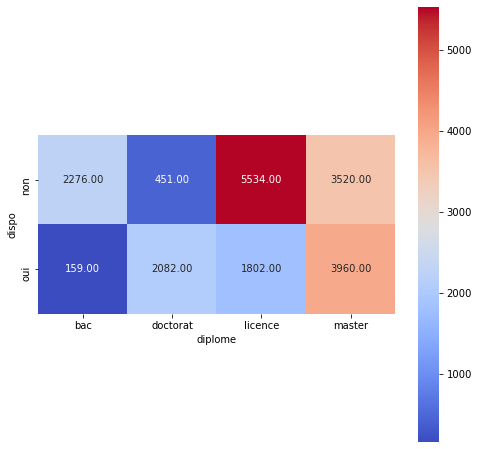


------------------------------




🔵 Features: dispo vs. specialite

 * Chi-Square Test of Independence:
   - Chi-Square Value: 2922.4259105585825
   - p-value: 0.0


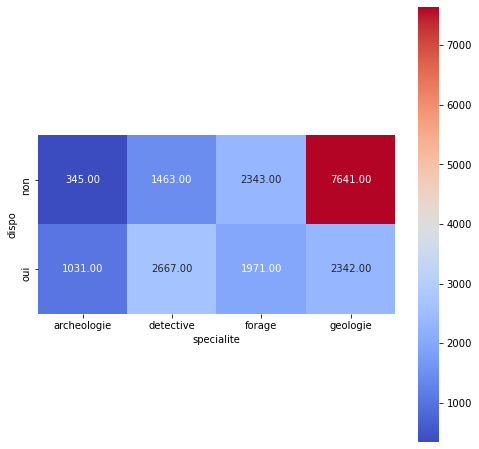


------------------------------




Finished! :D


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency

categorical_features = datac.select_dtypes(include='object').columns
categorical_features = categorical_features.drop('date')

for c1 in categorical_features:
    for c2 in categorical_features:
        if c1 != c2:
            print(f"🔵 Features: {c1} vs. {c2}\n")

            # Create contingency table
            contingency_table = pd.crosstab(datac[c1], datac[c2])

            # Chi-Square Test of Independence
            chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
            print(" * Chi-Square Test of Independence:")
            print("   - Chi-Square Value:", chi2)
            print("   - p-value:", p_chi2)

            # Plot the contingency table
            plt.figure(figsize=(8, 8))
            sns.heatmap(contingency_table, cmap="coolwarm", square=True, annot=True, fmt=".2f")
            plt.xlabel(c2)
            plt.ylabel(c1)
            plt.show()

            print("\n------------------------------\n\n\n\n")

print("Finished! :D")

In [15]:
print('No Hired', round(datac['embauche'].value_counts()[0]/len(datac) * 100,2), '% of the dataset')
print('Hired', round(datac['embauche'].value_counts()[1]/len(datac) * 100,2), '% of the dataset')

No Hired 88.54 % of the dataset
Hired 11.46 % of the dataset


Text(0.5, 1.0, 'embauche Distributions \n (0: No Hired || 1: Hired)')

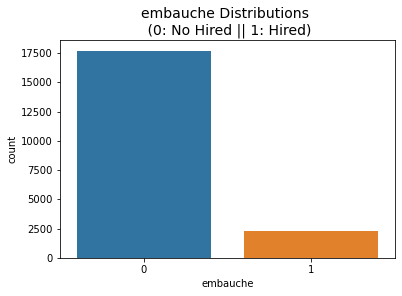

In [16]:
sns.countplot(data=datac, x='embauche')
plt.title('embauche Distributions \n (0: No Hired || 1: Hired)', fontsize=14)

# Step 4 - Dataset Editing

### Interpretation

We see that we have impossible combinations of data, it is not possible :
- for someone under 16 to have obtained their Baccalauréat
- for someone under 19 to have obtained their Licence degree
- for someone under 21 to have obtained their Master degree
- for someone under 23 to have obtained their Doctorate degree

Thus we are going to delete these elements

In [17]:
condition1 = (datac["age"] <= 19) & (datac["diplome"] == "licence")
condition2 = (datac["age"] <= 21) & (datac["diplome"] == "master")
condition3 = (datac["age"] <= 23) & (datac["diplome"] == "doctorat")
condition4 = (datac["age"] <= 16) & (datac["diplome"] == "bac")
datac = datac.loc[datac['age'] >= 0]
datac = datac.loc[datac['exp'] >= 0]

datac = datac[~(condition1 | condition2 | condition3 | condition4)]

<ipython-input-17-6f0e5f12286b>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datac = datac[~(condition1 | condition2 | condition3 | condition4)]


In [18]:
datac = datac.drop('index', axis=1)

In [19]:
datac[datac['age'] < 0]

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche


In [20]:
datac[datac['exp'] < 0]

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche


In [21]:
datac

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0
5,2014-02-12,chatain,37.0,8.0,38558.0,M,master,geologie,63.46,non,1
...,...,...,...,...,...,...,...,...,...,...,...
19994,2013-06-09,blond,33.0,9.0,32674.0,M,licence,geologie,65.23,non,0
19995,2012-03-10,roux,47.0,9.0,35723.0,M,licence,geologie,66.47,non,0
19996,2010-09-19,chatain,38.0,10.0,33570.0,F,master,geologie,62.29,non,1
19998,2011-12-06,chatain,33.0,11.0,34167.0,F,licence,detective,73.35,non,0


We are going to convert the following columns :
- date : converted into 2 columns (sine cosine) with cyclical feature encoding
- cheveux : One Hot Encoding
- age : float
- exp : float
- salaire : float
- sexe : int - One Hot Encoding (no label encoding to avoid hierarchy between numbers)
- diplome : int - One Hot Encoding
- specialite : int - One Hot Encoding
- note : float
- dispo : int - Label Encoding (boolean feature)
- embauche : int - Label Encoding (boolean feature) 

In [22]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd

# Step 1: Cyclical Feature Encoding for Date
datac['date'] = pd.to_datetime(datac['date'])
datac['day_of_year'] = datac['date'].dt.dayofyear
datac['date_sin'] = np.sin(2 * np.pi * datac['day_of_year']/365.25)
datac['date_cos'] = np.cos(2 * np.pi * datac['day_of_year']/365.25)
datac.drop(['date', 'day_of_year'], axis=1, inplace=True)

# Step 2-5: One Hot Encoding and Float Conversion
# Columns for one hot encoding
one_hot_columns = ['cheveux', 'sexe', 'diplome', 'specialite']
datac = pd.get_dummies(datac, columns=one_hot_columns)

# Converting 'age', 'exp', 'salaire', 'note' to float
float_columns = ['age', 'exp', 'salaire', 'note']
datac[float_columns] = datac[float_columns].astype(float)

# Step 6: Label Encoding for Boolean Features
label_encoder = LabelEncoder()
datac['dispo'] = label_encoder.fit_transform(datac['dispo'])

# Step 7: Handling NaN Values with KNN
imputer = KNNImputer(n_neighbors=5)
datac = pd.DataFrame(imputer.fit_transform(datac), columns=datac.columns)

# Display the transformed dataset
datac.head()

,age,exp,salaire,note,dispo,embauche,date_sin,date_cos,cheveux_blond,cheveux_brun,...,sexe_F,sexe_M,diplome_bac,diplome_doctorat,diplome_licence,diplome_master,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie
0,25.0,9.0,26803.0,97.08,0.0,0.0,0.472759,-0.881192,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,35.0,13.0,38166.0,63.86,0.0,0.0,0.943196,-0.332235,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,29.0,13.0,35207.0,78.50,0.0,0.0,-0.923158,-0.384421,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,35.0,6.0,28533.0,81.91,0.0,0.0,-0.599551,-0.800336,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,37.0,8.0,38558.0,63.46,0.0,1.0,0.674069,0.738668,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [23]:
import pandas as pd

# Initialize a dictionary to store type consistency and NaN percentage
type_consistency = {}

# Iterate through DataFrame columns
for column in datac:
    # Get the unique data types in the column
    unique_types = datac[column].apply(type).unique()
    
    # Calculate the percentage of NaN values in the column
    nan_percentage = datac[column].isna().mean() * 100

    # Construct the result string based on type consistency and NaN percentage
    if len(unique_types) == 1:
        consistency_result = f"🟢 {column}: Consistent ({unique_types[0].__name__})"
    else:
        consistency_result = f"🔴 {column}: Inconsistent ({', '.join(t.__name__ for t in unique_types)})"

    # Add the NaN percentage to the result string
    consistency_result += f"| NaN Values: {nan_percentage:.2f}% ({sum(datac[column].isna())})"

    # Store the result in the dictionary
    type_consistency[column] = consistency_result

# Print the type consistency results for each feature
for consistency in type_consistency.values():
    print(consistency + '\n')
    # Optionally write to an output file
    # output_file.write(consistency + '\n')

🟢 age: Consistent (float)| NaN Values: 0.00% (0)

🟢 exp: Consistent (float)| NaN Values: 0.00% (0)

🟢 salaire: Consistent (float)| NaN Values: 0.00% (0)

🟢 note: Consistent (float)| NaN Values: 0.00% (0)

🟢 dispo: Consistent (float)| NaN Values: 0.00% (0)

🟢 embauche: Consistent (float)| NaN Values: 0.00% (0)

🟢 date_sin: Consistent (float)| NaN Values: 0.00% (0)

🟢 date_cos: Consistent (float)| NaN Values: 0.00% (0)

🟢 cheveux_blond: Consistent (float)| NaN Values: 0.00% (0)

🟢 cheveux_brun: Consistent (float)| NaN Values: 0.00% (0)

🟢 cheveux_chatain: Consistent (float)| NaN Values: 0.00% (0)

🟢 cheveux_roux: Consistent (float)| NaN Values: 0.00% (0)

🟢 sexe_F: Consistent (float)| NaN Values: 0.00% (0)

🟢 sexe_M: Consistent (float)| NaN Values: 0.00% (0)

🟢 diplome_bac: Consistent (float)| NaN Values: 0.00% (0)

🟢 diplome_doctorat: Consistent (float)| NaN Values: 0.00% (0)

🟢 diplome_licence: Consistent (float)| NaN Values: 0.00% (0)

🟢 diplome_master: Consistent (float)| NaN Values:

In [24]:
dataf = datac.copy()

Our data is now cleaned and ready to work on!

Let's evaluate some common metrics:

- Accuracy: Measures the overall correctness of the model. However, it can be misleading in imbalanced datasets as it might reflect the underlying class distribution more than the model's ability to classify correctly.

- Precision: The ratio of true positives to all predicted positives. High precision indicates a low false positive rate but doesn't account for false negatives.

- Recall (Sensitivity): The ratio of true positives to all actual positives. High recall means the model is good at capturing the positive class but doesn't consider false positives.

- F1-Score: The harmonic mean of precision and recall. It's useful when you seek a balance between precision and recall and there's an uneven class distribution.

- ROC-AUC: Area under the Receiver Operating Characteristic curve. It's effective for binary classification problems to evaluate the trade-off between true positive rate and false positive rate.

- Precision-Recall AUC: Area under the precision-recall curve. This metric is particularly useful for imbalanced datasets.

Given the imbalance in the dataset, accuracy might not be the best metric. Instead, F1-Score, Precision-Recall AUC, or ROC-AUC could provide a more informative evaluation of your model's performance, especially in terms of its ability to correctly identify the minority class (candidates who were hired).

# Step 5 - Model Training

## Dataset splitting

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# Splitting the data into train (70%), validation (10%), and test (20%) sets
train_data, temp_data = train_test_split(dataf, test_size=0.3, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=(2/3), random_state=42)

# Output the sizes of each dataset
train_size = len(train_data)
validation_size = len(validation_data)
test_size = len(test_data)

train_size, test_size, validation_size

(12911, 3690, 1844)

In [27]:
target_variable = 'embauche'

# Splitting the data into X and y for training set
X_train = train_data.drop(columns=[target_variable])
y_train = train_data[target_variable]

# Splitting the data into X and y for validation set
X_validation = validation_data.drop(columns=[target_variable])
y_validation = validation_data[target_variable]

# Splitting the data into X and y for test set
X_test = test_data.drop(columns=[target_variable])
y_test = test_data[target_variable]

# Printing the shapes of X and y for each dataset
print("Shapes of X and y for training set:")
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

print("\nShapes of X and y for validation set:")
print("X_validation.shape:", X_validation.shape)
print("y_validation.shape:", y_validation.shape)

print("\nShapes of X and y for test set:")
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

Shapes of X and y for training set:
X_train.shape: (12911, 21)
y_train.shape: (12911,)

Shapes of X and y for validation set:
X_validation.shape: (1844, 21)
y_validation.shape: (1844,)

Shapes of X and y for test set:
X_test.shape: (3690, 21)
y_test.shape: (3690,)


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_and_evaluate_regression_models(X_train, y_train, X_validation, y_validation, models, param_grid):
    """
    Train and evaluate multiple regression machine learning models with hyperparameter tuning.

    Parameters:
    - X_train: Training features
    - y_train: Training labels (continuous values)
    - X_validation: Validation features
    - y_validation: Validation labels (continuous values)
    - models: A dictionary of regression models to try, where keys are model names and values are model objects
    - param_grid: A dictionary of hyperparameter grids for each model

    Returns:
    - A dictionary containing the best regression model, its hyperparameters, and regression evaluation metrics
    """
    best_model_info = {'model_name': None, 'best_model': None, 'best_params': None, 'mse': float('inf'), 'mae': float('inf'), 'r2_score': -float('inf')}
    
    for model_name, model in models.items():
        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(model, param_grid[model_name], cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        # Get the best regression model and its hyperparameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
        # Make predictions on the validation set
        y_validation_pred = best_model.predict(X_validation)
        
        # Calculate regression evaluation metrics
        mse = mean_squared_error(y_validation, y_validation_pred)
        mae = mean_absolute_error(y_validation, y_validation_pred)
        r2 = r2_score(y_validation, y_validation_pred)
        
        # Update best_model_info if the current model is better
        if mse < best_model_info['mse']:
            best_model_info['model_name'] = model_name
            best_model_info['best_model'] = best_model
            best_model_info['best_params'] = best_params
            best_model_info['mse'] = mse
            best_model_info['mae'] = mae
            best_model_info['r2_score'] = r2

    return best_model_info

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def train_and_evaluate_classifier_models(X_train, y_train, X_validation, y_validation, models, param_grid):
    """
    Train and evaluate multiple classifier machine learning models with hyperparameter tuning.

    Parameters:
    - X_train: Training features
    - y_train: Training labels (binary or multiclass)
    - X_validation: Validation features
    - y_validation: Validation labels (binary or multiclass)
    - models: A dictionary of classifier models to try, where keys are model names and values are model objects
    - param_grid: A dictionary of hyperparameter grids for each model

    Returns:
    - A dictionary containing the best classifier model, its hyperparameters, and classification evaluation metrics
    """
    best_model_info = {'model_name': None, 'best_model': None, 'best_params': None, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'roc_auc': 0, 'precision_recall_auc': 0}
    
    for model_name, model in models.items():
        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(model, param_grid[model_name], cv=3, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        # Get the best classifier model and its hyperparameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
        # Make predictions on the validation set
        y_validation_pred = best_model.predict(X_validation)
        
        # Calculate classification evaluation metrics
        accuracy = accuracy_score(y_validation, y_validation_pred)
        precision = precision_score(y_validation, y_validation_pred, average='weighted')
        recall = recall_score(y_validation, y_validation_pred, average='weighted')
        f1 = f1_score(y_validation, y_validation_pred, average='weighted')
        roc_auc = roc_auc_score(y_validation, y_validation_pred)
        
        # Calculate Precision-Recall AUC using average_precision_score
        precision_recall_auc = average_precision_score(y_validation, y_validation_pred, average='weighted')
        
        # Update best_model_info if the current model is better
        if accuracy > best_model_info['accuracy']:
            best_model_info['model_name'] = model_name
            best_model_info['best_model'] = best_model
            best_model_info['best_params'] = best_params
            best_model_info['accuracy'] = accuracy
            best_model_info['precision'] = precision
            best_model_info['recall'] = recall
            best_model_info['f1_score'] = f1
            best_model_info['roc_auc'] = roc_auc
            best_model_info['precision_recall_auc'] = precision_recall_auc

    return best_model_info

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

regression_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
}

regression_param_grid = {
    'Linear Regression': {},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]},
}

best_regression_model_info = train_and_evaluate_regression_models(X_train, y_train, X_validation, y_validation, regression_models, regression_param_grid)

In [31]:
best_regression_model_info

{'model_name': 'Random Forest',
 'best_model': RandomForestRegressor(max_depth=20, n_estimators=300),
 'best_params': {'max_depth': 20, 'n_estimators': 300},
 'mse': 0.06861838193438702,
 'mae': 0.14045068597074672,
 'r2_score': 0.3619196802748782}

In [32]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


classification_models = {
    'Logistic Regression': LogisticRegression(),
    'KNN Classifier': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
}

classification_param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l2']},
    'KNN Classifier': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'Decision Tree Classifier': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
}

best_classification_model_info = train_and_evaluate_classifier_models(X_train, y_train, X_validation, y_validation, classification_models, classification_param_grid)

D:\Programmes\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
best_classification_model_info

{'model_name': 'Decision Tree Classifier',
 'best_model': DecisionTreeClassifier(max_depth=10, min_samples_split=10),
 'best_params': {'max_depth': 10, 'min_samples_split': 10},
 'accuracy': 0.9002169197396963,
 'precision': 0.8871163079453741,
 'recall': 0.9002169197396963,
 'f1_score': 0.8888460727330033,
 'roc_auc': 0.6804751851406193,
 'precision_recall_auc': 0.3305498977001809}

# Step 6 - Model Testing

In [34]:
# 1. Import necessary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
best_model = best_classification_model_info['best_model']

# 2. Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# 3. Evaluate the predictions
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 4. Print the evaluation results
print("Test Set Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Test Set Evaluation Metrics:
Accuracy: 0.9021680216802168
Precision: 0.8879129476420151
Recall: 0.9021680216802168
F1 Score: 0.8881370794890294
Confusion Matrix:
 [[3178   75]
 [ 286  151]]


Decision Tree Classifier is the best model among the one tested with an accuracy of 90.21% which is a very good model : the model was able to predict correctly 90.21% of the dataset on unseen data.


## Evaluation Metrics Explanation
- Accuracy (90.2%):
    This indicates that the model correctly predicted whether a candidate was hired or not 90.2% of the time. While this might seem high, accuracy alone can be misleading, especially if the dataset is imbalanced (i.e., the number of hired vs. not hired candidates is significantly different).


- Precision (88.8%):
    Precision is the ratio of correctly predicted positive observations to the total predicted positives. Here, it tells us that when the model predicts a candidate will be hired, it is correct 88.8% of the time. High precision relates to a low false positive rate.


- Recall (90.2%):
    Recall (also known as sensitivity) measures the model's ability to identify actual positives. In this context, it indicates that the model successfully identified 90.2% of all candidates who were actually hired.


- F1 Score (88.8%):
    The F1 Score is a weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. An F1 Score of 88.8% is quite robust, suggesting a good balance between Precision and Recall.


- Confusion Matrix:
    The matrix: [[3178, 75], [286, 151]] can be interpreted as:
    
    True Negatives (TN) = 3178: Candidates correctly identified as not hired.
    
    False Positives (FP) = 75: Candidates incorrectly identified as hired.
    
    False Negatives (FN) = 286: Candidates incorrectly identified as not hired.
    
    True Positives (TP) = 151: Candidates correctly identified as hired.

## Analysis:
The Decision Tree Classifier demonstrates high accuracy, precision, recall, and F1 score.

The low number of True Positives (151) compared to True Negatives (3178) may indicate a class imbalance in the dataset. This imbalance could lead the Decision Tree to be biased towards predicting the majority class, which in this case is candidates not being hired.

A notable observation is the False Negative count (286) being almost twice that of the True Positive count (151). This suggests that the Decision Tree Classifier might be prone to overlooking candidates who are suitable for hiring.

## Recommendations for Improvement:

- Addressing Imbalance:
    If the dataset exhibits class imbalance, applying techniques like SMOTE (Synthetic Minority Over-sampling Technique, which is out of the scope since we didn't see that in class) or adjusting class weights in the Decision Tree can help in giving more importance to the minority class.

- Feature Engineering:
    Reevaluating and possibly enhancing the feature set used for training the Decision Tree. Effective feature engineering can significantly improve model performance. For example, categorizing continuous variables like 'age' or 'experience' into bins might yield better results.

- Model Complexity:
    Varying the complexity of the Decision Tree by experimenting with the tree depth. While a deeper tree can capture more complex patterns, it also risks overfitting. Appropriate pruning can strike a balance between model complexity and generalization.

- Cross-Validation:
    Implementing cross-validation techniques to ensure that the Decision Tree's performance is stable and consistent across different data subsets.

- Alternative Models:
    Testing other machine learning algorithms, particularly ensemble methods such as Random Forests or Gradient Boosting. These methods are generally more robust against class imbalance and can provide improved predictive performance.